## Alpha Insurance Modeling Notebook
#### This notebook is used for modeling and prediction


#### Importing Packages

In [1]:
import numpy as np
import pandas as pd
# import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
# Global variables
RANDOM_STATE = 0

## Import

In [2]:
#import statsmodels.api as sm
#from statsmodels.formula.api import ols

#def anova_test(x, data=data_train):
#    mod = ols('Fraudulent_Claim ~ {}'.format(x), data=data).fit()
#    aov_table = sm.stats.anova_lm(mod, tpy=2)
#    print(aov_table)

In [3]:
#anova_test('State_Code')

In [4]:
dtype = {
 'Annual_Premium': 'int64',
 'Claim_Amount': 'float64',
 'Claim_Cause': 'category',
 'Claim_Date': 'category',
 'Claim_Report_Type': 'category',
 'Claimant__Number': 'int64',
 'Education': 'category',
 'Employment_Status': 'category',
 'Fraudulent_Claim': 'category',
 'Gender': 'category',
 'Income': 'int64',
 'Location': 'category',
 'Marital_Status': 'category',
 'Monthly_Premium': 'int64',
 'Months_Since_Last_Claim': 'int64',
 'Months_Since_Policy_Inception': 'int64',
 'Outstanding_Balance': 'float64',
 'State': 'category',
 'State_Code': 'category',
 'Vehicle_Class': 'category',
 'Vehicle_Model': 'category',
 'Vehicle_Size': 'category'}
    
df0 = pd.read_csv('claim_data_v2_train.csv', dtype=dtype, usecols=[*dtype])

In [5]:
df0.head()

,State_Code,State,Claim_Amount,Education,Claim_Date,Employment_Status,Gender,Income,Location,Marital_Status,...,Months_Since_Last_Claim,Months_Since_Policy_Inception,Claim_Cause,Claim_Report_Type,Vehicle_Class,Vehicle_Size,Vehicle_Model,Outstanding_Balance,Fraudulent_Claim,Claimant__Number
0,KS,Kansas,575.560000,Bachelor,12/01/2018,Employed,F,56274,Suburban,Married,...,32,5,Collision,Agent,Two-Door Car,Midsize,Toyota,25781.0,N,1001
1,NE,Nebraska,697.953590,Bachelor,12/01/2018,Unemployed,F,0,NaN,Single,...,13,42,Scratch/Dent,Agent,Four-Door Car,Midsize,Chevrolet,37061.0,N,1002
2,OK,Oklahoma,1288.743165,Bachelor,12/01/2018,Employed,F,48767,Suburban,Married,...,18,38,Collision,Agent,Two-Door Car,Midsize,Chevrolet,17236.0,N,1003
3,MO,Missouri,764.586183,Bachelor,12/01/2018,Unemployed,M,0,Suburban,Married,...,18,65,Collision,Call Center,SUV,Midsize,Honda,30270.0,N,1004
4,KS,Kansas,281.369258,Bachelor,12/01/2018,Employed,M,43836,Rural,Single,...,52,44,Collision,Agent,Four-Door Car,Midsize,Ford,16263.0,N,1005


In [6]:
df0.columns

Index(['State_Code', 'State', 'Claim_Amount', 'Education', 'Claim_Date',
       'Employment_Status', 'Gender', 'Income', 'Location', 'Marital_Status',
       'Monthly_Premium', 'Annual_Premium', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Claim_Cause', 'Claim_Report_Type',
       'Vehicle_Class', 'Vehicle_Size', 'Vehicle_Model', 'Outstanding_Balance',
       'Fraudulent_Claim', 'Claimant__Number'],
      dtype='object')

#### Data Exploration was completed in separate notebooks for easier organization

## Test Train Split

In [7]:
from sklearn.model_selection import train_test_split 

num_test = 0.20 

data_train0, data_test0 = train_test_split(df0, test_size=num_test, random_state=RANDOM_STATE)

In [8]:
data_train0.shape

(4000, 22)

In [9]:
data_test0.shape

(1001, 22)

In [10]:
data_train0.to_csv("data_train0.csv")
data_test0.to_csv("data_test0.csv")

## Tranformations and Encoding
#### The coding before allows us to create functions to simplify, modify, and manipulate the data for better modeling and predicting. There are variables that we simplify, create bins for, change to 1,0 values etc.

In [11]:
def encode_target(df):
    # Convert Fraud Claim data from Y/N to 1/0
    df['Fraudulent_Claim'] = df['Fraudulent_Claim'].replace(('Y', 'N'), (1, 0))
    return df

In [12]:
def encode_gender(df):
    # Convert Gender data from M/F to 1/0
    df['Gender'] = df['Gender'].replace(('M', 'F'), (1, 0))
    return df

In [13]:
def simplify_employee(df):
    # Fill missing values with mode
    df['Employment_Status'] = df['Employment_Status'].fillna('Employed')
    
    # Encode as numeric representing years of schooling
    encode = {'Employed': 'Employed',
              'Unemployed': 'Unemployed',
              'Disabled': 'Employed',
              'Medical Leave': 'Medical Leave',
              'Retired': 'Retired'}
    
    df['Employment_Status'] = df['Employment_Status'].map(encode)
    return df

In [14]:
def encode_marital(df):
    # Convert Marital_Status data from Single/Married/Divorced to 0/1/2
    df['Marital_Status'] = df['Marital_Status'].replace(('Married', 'Single', 'Divorced'), (1, 0, 2))
    return df

In [15]:
def encode_vsize(df):
    # Convert Vehicle Size from Compact, Midsize, and Luxury to 1, 2, and 3
    df['Vehicle_Size'] = df['Vehicle_Size'].replace(('Compact', 'Midsize', 'Luxury'), (1,2,3))
    return df

In [16]:
def simplify_claim_amount(df):
    # Apply a log transformation to claim amount
    df['Claim_Amount'] = df['Claim_Amount'].apply(np.log)
    return df

In [17]:
def simplify_income(df):
    # Simplify income into bins
    bins = (-1, 10000, 50000, 90000, 999999999) 
    group_names = [0, 1, 2, 3] 
    categories = pd.cut(df['Income'], bins, labels=group_names) 
    df['Income'] = categories.astype('int8')
    return df

In [18]:
def simplify_location(df):
    # Fill missing values with mode
    df['Location'] = df['Location'].fillna('Suburban')
    return df

In [19]:
def simplify_outstanding_balance(df):
    # Fill missing values with 0 meaning there is no outstanding balance
    df['Outstanding_Balance'] = df['Outstanding_Balance'].fillna(0)
    return df

In [20]:
def simplify_education(df):
    # Fill missing values with mode
    df['Education'] = df['Education'].fillna('College')
    
    # Encode as numeric representing years of schooling
    encode = {'High School or Below': 'High School or Below',
              'College': 'College',
              'Bachelor': 'Bachelor',
              'Master': 'Graduate',
              'Doctor': 'Graduate'}

    df['Education'] = df['Education'].map(encode)
    return df

In [21]:
def simplify_claim_cause(df):

    # Encode as numeric representing years of schooling
    encode = {'Collision': 'Collision',
              'Hail': 'Hail',
              'Scratch/Dent': 'Scratch/Dent',
              'Other': 'Other',
              'Fire': 'Fire'}

    df['Claim_Cause'] = df['Claim_Cause'].map(encode)
    return df

In [22]:
def drop_features(df):
    features = ['State', 'Annual_Premium', 'Vehicle_Model']
    df = df.drop(features, axis='columns')
    return df

#### The code below is what transforms the data based on the code blocks above

In [23]:
def transform_features(df):
    df = encode_target(df)
    df = encode_gender(df)
    df = simplify_employee(df)
    df = encode_marital(df)
    df = encode_vsize(df)
    df = simplify_claim_amount(df)
    df = simplify_income(df)
    df = simplify_location(df)
    df = simplify_outstanding_balance(df)
    df = simplify_education(df)
    df = simplify_claim_cause(df)
    df = drop_features(df)
    return df

In [24]:
data_train = transform_features(data_train0.copy(deep=True))

In [25]:
data_test = transform_features(data_test0.copy(deep=True))

#### Checking to see if missing values were filled correctly

In [26]:
data_train.isna().sum()

State_Code                       0
Claim_Amount                     0
Education                        0
Claim_Date                       0
Employment_Status                0
Gender                           0
Income                           0
Location                         0
Marital_Status                   0
Monthly_Premium                  0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Claim_Cause                      0
Claim_Report_Type                0
Vehicle_Class                    0
Vehicle_Size                     0
Outstanding_Balance              0
Fraudulent_Claim                 0
Claimant__Number                 0
dtype: int64

In [27]:
data_train.head()

,State_Code,Claim_Amount,Education,Claim_Date,Employment_Status,Gender,Income,Location,Marital_Status,Monthly_Premium,Months_Since_Last_Claim,Months_Since_Policy_Inception,Claim_Cause,Claim_Report_Type,Vehicle_Class,Vehicle_Size,Outstanding_Balance,Fraudulent_Claim,Claimant__Number
2715,MO,6.506815,Graduate,12/15/2018,Employed,0,2,Rural,1,58,18,79,Hail,Call Center,Four-Door Car,2,30634.0,0,3716
788,IA,5.446624,College,12/01/2018,Unemployed,0,0,Suburban,0,104,31,53,Scratch/Dent,Branch,Four-Door Car,2,10658.0,0,1789
1457,MO,6.200470,High School or Below,12/01/2018,Unemployed,0,0,Suburban,0,91,25,21,Other,Call Center,Four-Door Car,2,41743.0,0,2458
3568,IA,6.046150,Bachelor,12/15/2018,Unemployed,1,0,Suburban,0,80,9,88,Collision,Call Center,Four-Door Car,2,46886.0,0,4569
3529,IA,6.571308,High School or Below,12/15/2018,Employed,1,2,Suburban,1,69,9,81,Other,Agent,Four-Door Car,3,45168.0,0,4530


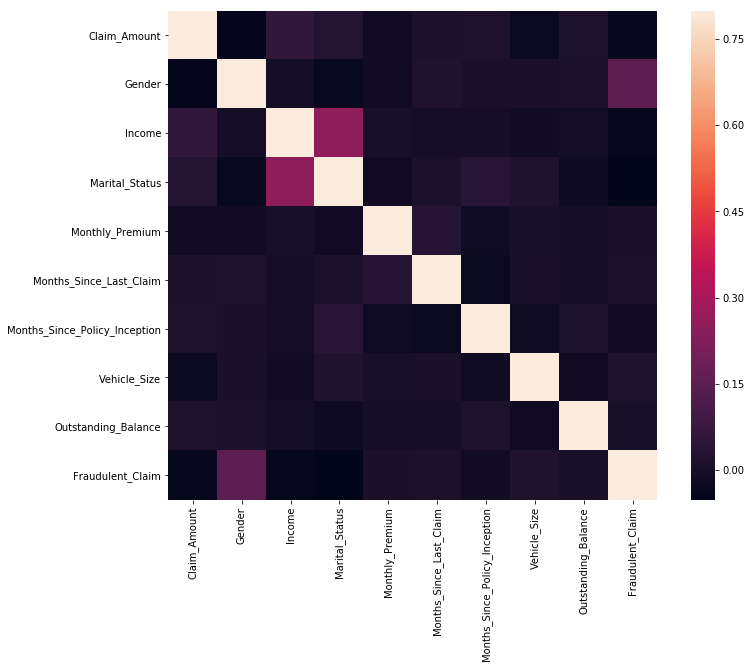

In [28]:
corrmat= data_train.drop('Claimant__Number', axis='columns').corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## Encoding
#### The code below creates a function that can encode the data in one take

In [29]:
def one_hot_encode(columns, train, test):
    df_train = pd.get_dummies(train, columns=columns, prefix=columns)
    print("Train Original Shape:", df_train.shape)
    df_test = pd.get_dummies(test, columns=columns, prefix=columns)
    print("Test Original Shape:", df_test.shape)
    final_train, final_test = df_train.align(df_test, join='inner', axis=1)  # inner join - return only columns that are the same
    return final_train, final_test

In [30]:
# Chose the columns to one hot encode
columns = ['Vehicle_Class', 'Employment_Status', 'Education', 'State_Code', 'Claim_Date', 'Location', 'Claim_Cause', 'Claim_Report_Type']

In [31]:
train_encoded, test_encoded = one_hot_encode(columns, data_train, data_test)

Train Original Shape: (4000, 45)
Test Original Shape: (1001, 44)


In [32]:
train_encoded.shape

(4000, 44)

In [33]:
test_encoded.shape

(1001, 44)

In [34]:
train_encoded.columns

Index(['Claim_Amount', 'Gender', 'Income', 'Marital_Status', 'Monthly_Premium',
       'Months_Since_Last_Claim', 'Months_Since_Policy_Inception',
       'Vehicle_Size', 'Outstanding_Balance', 'Fraudulent_Claim',
       'Claimant__Number', 'Vehicle_Class_Four-Door Car',
       'Vehicle_Class_Luxury Car', 'Vehicle_Class_Luxury SUV',
       'Vehicle_Class_SUV', 'Vehicle_Class_Sports Car',
       'Vehicle_Class_Two-Door Car', 'Employment_Status_Employed',
       'Employment_Status_Medical Leave', 'Employment_Status_Retired',
       'Employment_Status_Unemployed', 'Education_Bachelor',
       'Education_College', 'Education_Graduate',
       'Education_High School or Below', 'State_Code_IA', 'State_Code_KS',
       'State_Code_MO', 'State_Code_NE', 'State_Code_OK',
       'Claim_Date_01/15/2019', 'Claim_Date_12/01/2018',
       'Claim_Date_12/15/2018', 'Location_Rural', 'Location_Suburban',
       'Location_Urban', 'Claim_Cause_Collision', 'Claim_Cause_Hail',
       'Claim_Cause_Other', 'C

In [35]:
train_encoded.dtypes

Claim_Amount                       float64
Gender                               int64
Income                                int8
Marital_Status                       int64
Monthly_Premium                      int64
Months_Since_Last_Claim              int64
Months_Since_Policy_Inception        int64
Vehicle_Size                         int64
Outstanding_Balance                float64
Fraudulent_Claim                     int64
Claimant__Number                     int64
Vehicle_Class_Four-Door Car          uint8
Vehicle_Class_Luxury Car             uint8
Vehicle_Class_Luxury SUV             uint8
Vehicle_Class_SUV                    uint8
Vehicle_Class_Sports Car             uint8
Vehicle_Class_Two-Door Car           uint8
Employment_Status_Employed           uint8
Employment_Status_Medical Leave      uint8
Employment_Status_Retired            uint8
Employment_Status_Unemployed         uint8
Education_Bachelor                   uint8
Education_College                    uint8
Education_G

In [36]:
import numpy as np
X = np.array(train_encoded.ix[:, train_encoded.columns != 'Fraudulent_Claim'])
y = np.array(train_encoded.ix[:, train_encoded.columns == 'Fraudulent_Claim'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (4000, 43)
Shape of y: (4000, 1)


c:\users\student\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\users\student\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


## Oversampling Code
#### Oversampling the non fraud claims to match the number of fraud claims

In [37]:
#Finds the number of non-fraud samples 
no_non_frauds = len(train_encoded[train_encoded['Fraudulent_Claim'] == 0])

#gets indices of fraud samples
fraud_indices = train_encoded[train_encoded.Fraudulent_Claim == 1].index

#Random sample fraud indices (with replacement)
random_indices = np.random.choice(fraud_indices, no_non_frauds, replace=True)

#Find the indices of nonfraud samples
non_fraud_indices = train_encoded[train_encoded.Fraudulent_Claim == 0].index

#Concat fraud indices with sample non-fraud ones
over_sample_indices = np.concatenate([non_fraud_indices, random_indices])

#Get Balance Dataframe
over_sample = train_encoded.loc[over_sample_indices]

#Results
over_sample["Fraudulent_Claim"].describe()

count    7510.000000
mean        0.500000
std         0.500033
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Fraudulent_Claim, dtype: float64

## Undersampling
#### The code below undersamples the majority class

In [38]:
#Finds the number of fraud samples 
no_frauds = len(train_encoded[train_encoded['Fraudulent_Claim'] == 1])

#gets indices of nonfraud samples
non_fraud_indices = train_encoded[train_encoded.Fraudulent_Claim == 0].index

#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices, no_frauds, replace=False, )

#Find the indices of fraud samples
fraud_indices = train_encoded[train_encoded.Fraudulent_Claim == 1].index

#Concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices, random_indices])

#Get Balance Dataframe
under_sample = train_encoded.loc[under_sample_indices]

#Results
under_sample["Fraudulent_Claim"].describe()

count    490.000000
mean       0.500000
std        0.500511
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: Fraudulent_Claim, dtype: float64

## Modeling

Select dataframe to use for modeling

In [39]:
data_modeling = train_encoded.copy(deep=True)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### The code below creates our Modeling Pipeline

In [41]:
models = {}

In [42]:
def run_model(ID, clf, train, test):
    # Split X=independent variables and y=dependent variable
    X_train = train.drop(["Claimant__Number", "Fraudulent_Claim"], axis="columns")
    X_test = test.drop(["Claimant__Number", "Fraudulent_Claim"], axis="columns")
    y_train = train["Fraudulent_Claim"]
    y_test = test["Fraudulent_Claim"]
    
    # Train model
    clf.fit(X_train, y_train)
    
    # Make predictions
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    # Get fraud prediction percent
    train_fraud_pct = np.array(train_predictions).mean()
    test_fraud_pct = np.array(test_predictions).mean()
    
    # Score predictions
    train_score = accuracy_score(y_train, train_predictions)
    test_score = accuracy_score(y_test, test_predictions)
    
    confusion_mtx = confusion_matrix(y_test, test_predictions)
    tn, fp, fn, tp = confusion_mtx.ravel()
    
    # Save model and results to dictionary
    models[ID] = {"clf": clf,
                  "test_score": test_score, 
                  "train_score": train_score,
                  "test_pred_pct_fraud": test_fraud_pct,
                  "train_pred_pct_fraud": train_fraud_pct,
                  "true negative": tn,
                  "false positive": fp,
                  "false negative": fn,
                  "true positive": tp
                 }
    
    # Pretty-Print results
    pprint(models[ID])
    print("Confusion Matrix:\n", confusion_mtx)    

#### Simple Model (Predict all are not fraud)

In [43]:
class simple_model():
    def __repr__(self):
        return "Predicts non-fraud for everyone"
    
    def fit(self, X, y):
        pass
    
    def predict(self, X, prediction=0):
        return np.array([prediction]*len(X))

In [44]:
clf = simple_model()

In [45]:
run_model("Simple Model", clf, train_encoded, test_encoded)

{'clf': Predicts non-fraud for everyone,
 'false negative': 62,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.938061938061938,
 'train_pred_pct_fraud': 0.0,
 'train_score': 0.93875,
 'true negative': 939,
 'true positive': 0}
Confusion Matrix:
 [[939   0]
 [ 62   0]]


### Imbalanced Data

#### Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE,
                            max_depth=5
                            )

In [48]:
run_model("Decision Tree - Imbalanced Data", clf, train_encoded, test_encoded)

{'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
 'false negative': 62,
 'false positive': 3,
 'test_pred_pct_fraud': 0.002997002997002997,
 'test_score': 0.935064935064935,
 'train_pred_pct_fraud': 0.0015,
 'train_score': 0.94025,
 'true negative': 936,
 'true positive': 0}
Confusion Matrix:
 [[936   3]
 [ 62   0]]


#### Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE,
                            max_depth=12
                            )

In [51]:
run_model("Gradient Boosting - Imbalanced Data", clf, train_encoded, test_encoded)

{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
 'false negative': 61,
 'false positive': 5,
 'test_pred_pct_fraud': 0.005994005994005994,
 'test_score': 0.9340659340659341,
 'train_pred_pct_fraud': 0.06125,
 'train_score': 1.0,
 'true negative': 934,
 'true positive': 1}
Confusion Matrix:
 [[934   5]
 [ 61   1]]


#### Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
clf = LogisticRegression(random_state=RANDOM_STATE)

In [54]:
run_model("Logistic Regression - Imbalanced Data", clf, train_encoded, test_encoded)

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
 'false negative': 62,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.938061938061938,
 'train_pred_pct_fraud': 0.0,
 'train_score': 0.93875,
 'true negative': 939,
 'true positive': 0}
Confusion Matrix:
 [[939   0]
 [ 62   0]]


c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Neural Network

In [55]:
from sklearn.neural_network import MLPClassifier

In [56]:
clf = MLPClassifier(random_state=RANDOM_STATE)

In [57]:
run_model("Neural Net - Imbalanced Data", clf, train_encoded, test_encoded)

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
 'false negative': 62,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.938061938061938,
 'train_pred_pct_fraud': 0.0015,
 'train_score': 0.93875,
 'true negative': 939,
 'true positive': 0}
Confusion Matrix:
 [[939   0]
 [ 62   0]]


#### Support Vector Machine

In [58]:
from sklearn.svm import SVC

In [59]:
clf = SVC(random_state=RANDOM_STATE)

In [60]:
run_model("SVM - Imbalanced Data", clf, train_encoded, test_encoded)

c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
 'false negative': 62,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.938061938061938,
 'train_pred_pct_fraud': 0.06125,
 'train_score': 1.0,
 'true negative': 939,
 'true positive': 0}
Confusion Matrix:
 [[939   0]
 [ 62   0]]


### Undersampled Data

#### Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE,
                            max_depth=5
                            )

In [63]:
run_model("Decision Tree - Under Sampled", clf, under_sample, test_encoded)

{'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
 'false negative': 2,
 'false positive': 404,
 'test_pred_pct_fraud': 0.46353646353646355,
 'test_score': 0.5944055944055944,
 'train_pred_pct_fraud': 0.6795918367346939,
 'train_score': 0.8,
 'true negative': 535,
 'true positive': 60}
Confusion Matrix:
 [[535 404]
 [  2  60]]


#### Gradient Boosting

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE,
                            max_depth=12
                            )

In [66]:
run_model("Gradient Boosting - Under Sampled", clf, under_sample, test_encoded)

{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
 'false negative': 20,
 'false positive': 294,
 'test_pred_pct_fraud': 0.3356643356643357,
 'test_score': 0.6863136863136863,
 'train_pred_pct_fraud': 0.5,
 'train_score': 1.0,
 'true negative': 645,
 'true positive': 42}
Confusion Matrix:
 [[645 294]
 [ 20  42]]


#### Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
clf = LogisticRegression(random_state=RANDOM_STATE)

In [69]:
run_model("Logistic Regression - Under Sampled", clf, under_sample, test_encoded)

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
 'false negative': 11,
 'false positive': 316,
 'test_pred_pct_fraud': 0.36663336663336665,
 'test_score': 0.6733266733266733,
 'train_pred_pct_fraud': 0.5795918367346938,
 'train_score': 0.7857142857142857,
 'true negative': 623,
 'true positive': 51}
Confusion Matrix:
 [[623 316]
 [ 11  51]]


c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Neural Network

In [70]:
from sklearn.neural_network import MLPClassifier

In [71]:
clf = MLPClassifier(random_state=RANDOM_STATE)

In [72]:
run_model("Neural Net - Under Sampled", clf, under_sample, test_encoded)

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
 'false negative': 3,
 'false positive': 919,
 'test_pred_pct_fraud': 0.977022977022977,
 'test_score': 0.07892107892107893,
 'train_pred_pct_fraud': 0.9816326530612245,
 'train_score': 0.5142857142857142,
 'true negative': 20,
 'true positive': 59}
Confusion Matrix:
 [[ 20 919]
 [  3  59]]


#### Support Vector Machine

In [73]:
from sklearn.svm import SVC

In [74]:
clf = SVC(random_state=RANDOM_STATE)

In [75]:
run_model("SVM - Under Sampled", clf, under_sample, test_encoded)

c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
 'false negative': 0,
 'false positive': 934,
 'test_pred_pct_fraud': 0.995004995004995,
 'test_score': 0.06693306693306693,
 'train_pred_pct_fraud': 0.5,
 'train_score': 1.0,
 'true negative': 5,
 'true positive': 62}
Confusion Matrix:
 [[  5 934]
 [  0  62]]


## OverSampled Data

#### Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [77]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE,
                            max_depth=5
                            )

In [78]:
run_model("Decision Tree - Over Sampled", clf, over_sample , test_encoded)

{'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
 'false negative': 5,
 'false positive': 373,
 'test_pred_pct_fraud': 0.42957042957042957,
 'test_score': 0.6223776223776224,
 'train_pred_pct_fraud': 0.6834886817576564,
 'train_score': 0.7944074567243675,
 'true negative': 566,
 'true positive': 57}
Confusion Matrix:
 [[566 373]
 [  5  57]]



#### Gradient Boosting

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

In [80]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE,
                            max_depth=12
                            )

In [81]:
run_model("Gradient Boosting - Over Sampled", clf, over_sample, test_encoded)

{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
 'false negative': 61,
 'false positive': 7,
 'test_pred_pct_fraud': 0.007992007992007992,
 'test_score': 0.932067932067932,
 'train_pred_pct_fraud': 0.5,
 'train_score': 1.0,
 'true negative': 932,
 'true positive': 1}
Confusion Matrix:
 [[932   7]
 [ 61   1]]


#### Logistic Regression


In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
clf = LogisticRegression(random_state=RANDOM_STATE)

In [84]:
run_model("Logistic Regression - Over Sampled", clf, over_sample, test_encoded)

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
 'false negative': 13,
 'false positive': 298,
 'test_pred_pct_fraud': 0.34665334665334663,
 'test_score': 0.6893106893106893,
 'train_pred_pct_fraud': 0.5733688415446072,
 'train_score': 0.7673768308921438,
 'true negative': 641,
 'true positive': 49}
Confusion Matrix:
 [[641 298]
 [ 13  49]]


c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Neural Networking


In [85]:
from sklearn.neural_network import MLPClassifier

In [86]:
clf = MLPClassifier(random_state=RANDOM_STATE)

In [87]:
run_model("Neural Net - Over Sampled", clf, over_sample, test_encoded)

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
 'false negative': 3,
 'false positive': 911,
 'test_pred_pct_fraud': 0.9690309690309691,
 'test_score': 0.08691308691308691,
 'train_pred_pct_fraud': 0.9840213049267643,
 'train_score': 0.5159786950732357,
 'true negative': 28,
 'true positive': 59}
Confusion Matrix:
 [[ 28 911]
 [  3  59]]


#### Support Vector Machine


In [88]:
from sklearn.svm import SVC

In [89]:
clf = SVC(random_state=RANDOM_STATE)

In [90]:
run_model("SVM - Over Sampled", clf, over_sample, test_encoded)

c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
 'false negative': 62,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.938061938061938,
 'train_pred_pct_fraud': 0.5,
 'train_score': 1.0,
 'true negative': 939,
 'true positive': 0}
Confusion Matrix:
 [[939   0]
 [ 62   0]]


#### Model Selection

In [112]:
pd.DataFrame(models).transpose().drop("clf", axis=1)

,false negative,false positive,test_pred_pct_fraud,test_score,train_pred_pct_fraud,train_score,true negative,true positive
Simple Model,62,0,0,0.938062,0,0.93875,939,0
Decision Tree - Imbalanced Data,62,3,0.002997,0.935065,0.0015,0.94025,936,0
Gradient Boosting - Imbalanced Data,61,5,0.00599401,0.934066,0.06125,1,934,1
Logistic Regression - Imbalanced Data,62,0,0,0.938062,0,0.93875,939,0
Neural Net - Imbalanced Data,62,0,0,0.938062,0.0015,0.93875,939,0
SVM - Imbalanced Data,62,0,0,0.938062,0.06125,1,939,0
Decision Tree - Under Sampled,2,404,0.463536,0.594406,0.679592,0.8,535,60
Gradient Boosting - Under Sampled,20,294,0.335664,0.686314,0.5,1,645,42
Logistic Regression - Under Sampled,11,316,0.366633,0.673327,0.579592,0.785714,623,51
Neural Net - Under Sampled,3,919,0.977023,0.0789211,0.981633,0.514286,20,59


## Testing

In [92]:
mdl = models["Logistic Regression - Over Sampled"]["clf"]

In [93]:
df_test0 = pd.read_csv('Claim_Score_Dataset.csv', dtype=dtype, usecols=[*dtype])

Replace claim date 01/10/2020 with 01/15/2019 because the 01/10/2020 date did not appear in the training data

In [94]:
df_test0a = df_test0.replace(('01/10/2020'), ('01/15/2019'))

In [95]:
data_test1 = transform_features(df_test0a.copy(deep=True))

In [96]:
def one_hot_encode(columns, train, test):
    df_train = pd.get_dummies(train, columns=columns, prefix=columns)
    print("Train Original Shape:", df_train.shape)
    df_test = pd.get_dummies(test, columns=columns, prefix=columns)
    print("Test Original Shape:", df_test.shape)
    final_train, final_test = df_train.align(df_test, join='outer', axis=1)  # inner join - return only columns that are the same
    return final_train, final_test

In [97]:
# Chose the columns to one hot encode
columns = ['Vehicle_Class', 'Employment_Status', 'Education', 'State_Code', 'Claim_Date', 'Location', 'Claim_Cause', 'Claim_Report_Type']

_, df_test_encoded = one_hot_encode(columns, data_train, data_test1)

Train Original Shape: (4000, 45)
Test Original Shape: (4008, 42)


In [98]:
df_test_encoded.shape

(4008, 45)

In [99]:
df_test_encoded.head()

,Claim_Amount,Claim_Cause_Collision,Claim_Cause_Fire,Claim_Cause_Hail,Claim_Cause_Other,Claim_Cause_Scratch/Dent,Claim_Date_01/15/2019,Claim_Date_12/01/2018,Claim_Date_12/15/2018,Claim_Report_Type_Agent,...,State_Code_MO,State_Code_NE,State_Code_OK,Vehicle_Class_Four-Door Car,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car,Vehicle_Size
0,7.132611,1,NaN,0,0,0,1,NaN,NaN,0,...,0,0,1,0,0,0,0,0,1,3
1,6.811225,0,NaN,0,1,0,1,NaN,NaN,1,...,0,0,0,0,0,0,1,0,0,2
2,6.656367,0,NaN,1,0,0,1,NaN,NaN,0,...,0,1,0,0,0,0,0,0,1,2
3,6.328237,1,NaN,0,0,0,1,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,2
4,5.846161,0,NaN,0,0,1,1,NaN,NaN,0,...,0,1,0,1,0,0,0,0,0,2


In [100]:
df_test_encoded.isna().sum()

Claim_Amount                          0
Claim_Cause_Collision                 0
Claim_Cause_Fire                   4008
Claim_Cause_Hail                      0
Claim_Cause_Other                     0
Claim_Cause_Scratch/Dent              0
Claim_Date_01/15/2019                 0
Claim_Date_12/01/2018              4008
Claim_Date_12/15/2018              4008
Claim_Report_Type_Agent               0
Claim_Report_Type_Branch              0
Claim_Report_Type_Call Center         0
Claim_Report_Type_Web                 0
Claimant__Number                      0
Education_Bachelor                    0
Education_College                     0
Education_Graduate                    0
Education_High School or Below        0
Employment_Status_Employed            0
Employment_Status_Medical Leave       0
Employment_Status_Retired             0
Employment_Status_Unemployed          0
Fraudulent_Claim                      0
Gender                                0
Income                                0


In [101]:
df_test_encoded = df_test_encoded.fillna(0)

In [102]:
df_test_encoded.head()

,Claim_Amount,Claim_Cause_Collision,Claim_Cause_Fire,Claim_Cause_Hail,Claim_Cause_Other,Claim_Cause_Scratch/Dent,Claim_Date_01/15/2019,Claim_Date_12/01/2018,Claim_Date_12/15/2018,Claim_Report_Type_Agent,...,State_Code_MO,State_Code_NE,State_Code_OK,Vehicle_Class_Four-Door Car,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car,Vehicle_Size
0,7.132611,1,0.0,0,0,0,1,0.0,0.0,0,...,0,0,1,0,0,0,0,0,1,3
1,6.811225,0,0.0,0,1,0,1,0.0,0.0,1,...,0,0,0,0,0,0,1,0,0,2
2,6.656367,0,0.0,1,0,0,1,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,2
3,6.328237,1,0.0,0,0,0,1,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,2
4,5.846161,0,0.0,0,0,1,1,0.0,0.0,0,...,0,1,0,1,0,0,0,0,0,2


In [103]:
df_test_encoded.shape

(4008, 45)

In [104]:
train_encoded.shape

(4000, 44)

Drop Claim Cause Fire because of how it was encoded. It did not have a column in the model training set

In [105]:
df_test_encoded2 = df_test_encoded.drop("Claim_Cause_Fire", axis="columns")

In [113]:
test_results = {}

In [114]:
def test_model(ID, clf, test):
    # Split X=independent variables and y=dependent variable
    X_test = test.drop(["Claimant__Number", "Fraudulent_Claim"], axis="columns")
    y_test = test["Fraudulent_Claim"]
    
    # Make predictions
    test_predictions = clf.predict(X_test)
    
    # Get fraud prediction percent
    test_fraud_pct = np.array(test_predictions).mean()
    
    # Score predictions
    test_score = accuracy_score(y_test, test_predictions)
    
    confusion_mtx = confusion_matrix(y_test, test_predictions)
    tn, fp, fn, tp = confusion_mtx.ravel()
    
    # Save model and results to dictionary
    test_results[ID] = {"clf": clf,
                  "test_score": test_score, 
                  "test_pred_pct_fraud": test_fraud_pct,
                  "true negative": tn,
                  "false positive": fp,
                  "false negative": fn,
                  "true positive": tp
                 }
    
    # Pretty-Print results
    pprint(test_results[ID])
    print("Confusion Matrix:\n", confusion_mtx)   

Test all models that are saved using new test data

In [115]:
for m, n in models.items():
    mdl = n["clf"]
    print(m)
    if n["clf"] != "Predicts non-fraud for everyone":
        test_model(m + " - Testing Results", mdl, df_test_encoded2)
        print()

Simple Model
{'clf': Predicts non-fraud for everyone,
 'false negative': 578,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.8557884231536926,
 'true negative': 3430,
 'true positive': 0}
Confusion Matrix:
 [[3430    0]
 [ 578    0]]

Decision Tree - Imbalanced Data
{'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
 'false negative': 577,
 'false positive': 18,
 'test_pred_pct_fraud': 0.004740518962075849,
 'test_score': 0.8515469061876247,
 'true negative': 3412,
 'true positive': 1}
Confusion Matrix:
 [[3412   18]
 [ 577    1]]

Gradient Boosting - Imbalanced Data
{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1

{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
 'false negative': 578,
 'false positive': 0,
 'test_pred_pct_fraud': 0.0,
 'test_score': 0.8557884231536926,
 'true negative': 3430,
 'true positive': 0}
Confusion Matrix:
 [[3430    0]
 [ 578    0]]



## Display testing results

In [116]:
pd.DataFrame(test_results).transpose().drop("clf", axis=1)

,false negative,false positive,test_pred_pct_fraud,test_score,true negative,true positive
Simple Model - Testing Results,578,0,0,0.855788,3430,0
Decision Tree - Imbalanced Data - Testing Results,577,18,0.00474052,0.851547,3412,1
Gradient Boosting - Imbalanced Data - Testing Results,565,98,0.0276946,0.834581,3332,13
Logistic Regression - Imbalanced Data - Testing Results,577,0,0.000249501,0.856038,3430,1
Neural Net - Imbalanced Data - Testing Results,578,0,0,0.855788,3430,0
SVM - Imbalanced Data - Testing Results,578,0,0,0.855788,3430,0
Decision Tree - Under Sampled - Testing Results,294,1798,0.519461,0.478044,1632,284
Gradient Boosting - Under Sampled - Testing Results,415,959,0.27994,0.657186,2471,163
Logistic Regression - Under Sampled - Testing Results,578,0,0,0.855788,3430,0
Neural Net - Under Sampled - Testing Results,578,2,0.000499002,0.855289,3428,0
